# Get Buildings and Streets and run Morphometrics

Gets buildings and streets layer and create morphometrics statistics.

# Import modules

In [1]:
import numpy as np
import pandas as pd
import osmnx as ox
import networkx as nx
import geopandas as gpd
import imageio
import momepy
import math

import time

from pathlib import Path

import warnings
warnings.filterwarnings("ignore")



# Choose City

In [2]:
city_list = [
    'Melbourne',
    'Jerusalem',
    'Buenos Aires',
    'Paris',
    'Rotterdam',
    'Nashville',
    'Singapore',
    'Cape Town',
    'New York',
    'Los Angeles',
    'Chicago',
    'Boston',
    'Austin',
    'Seattle',
    'Philadelphia',
    'Pittsburgh',
    'Washington DC',
    'San Francisco',
    'SF Bay Area ',
    'Raleigh',
    'Milwaukee',
    'Portland',
    'San Diego',
    'Denver',
    'Miami',
    'Saint Louis',
    'Houston',
    'Atlanta',
    'Phoenix',
    'Detroit',
    'Minneapolis',
    'Savannah',
    'Charlotte',
    'Las Vegas',
    'Cincinnati',
    'Kansas City',
    'Nashville']

In [3]:
city = city_list[8]
print("City:", city)

City: New York


# Buildings and Streets

## Read Geopackage

In [4]:
data_folder = Path("../data/")
input_file = data_folder / "0_boundaries" / (city + ".gpkg")

gdf = gpd.read_file(input_file, driver='GPKG')
# Force gdf projection
print("Reading:", input_file)
gdf = ox.project_gdf(gdf,to_crs='epsg:4326',to_latlong=False) 

Reading: ../data/0_boundaries/New York.gpkg


<Axes: >

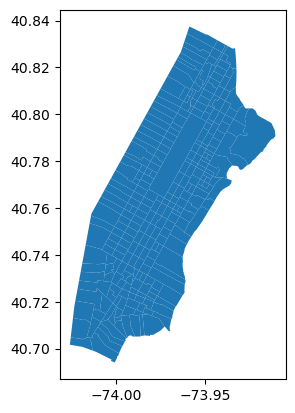

In [5]:
gdf.plot()

## Get Master polygon

In [6]:
# Create unique ID
gdf = gdf.reset_index(drop=True)
gdf['UID'] = gdf.index

# Establish bounds DataFrame (everything so we can do one query)
gdf['collapse'] = 0
gdf_collapsed = gdf.dissolve(by='collapse')

## Get Streets

In [7]:
G = ox.graph_from_polygon(gdf_collapsed['geometry'][0], network_type='drive', retain_all=True) 
out_file = data_folder / "1_buildings_streets" / (city + " - streets.gpkg")
ox.save_graph_geopackage(G, filepath=out_file)
print("Saved:", out_file)

Saved: ../data/1_buildings_streets/New York - streets.gpkg


## Get Buildings

In [8]:
tags = {"building": True}
buildings = ox.geometries_from_polygon(gdf_collapsed['geometry'][0], tags)
buildings = buildings[['geometry','name']]
buildings_save = buildings.drop(labels="node", axis=0)

# Save
out_file = data_folder / "1_buildings_streets" / (city + " - buildings.gpkg")
buildings_save.to_file(out_file, driver='GPKG')
print("Saved:", out_file)

/tmp/ipykernel_85208/3045846604.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  buildings_save = buildings.drop(labels="node", axis=0)


Saved: ../data/1_buildings_streets/New York - buildings.gpkg


# Morphometrics

## Helper functions

In [9]:
def reverse_bearing(x):
    return x + 180 if x < 180 else x - 180

def get_bearings(G, ID):
    # calculate the edge bearings
    Gu = ox.add_edge_bearings(ox.get_undirected(G))
    
    weight_by_length = False

    bearings = {}
    if weight_by_length:
        # weight bearings by length (meters)
        city_bearings = []
        for u, v, k, d in Gu.edges(keys=True, data=True):
            city_bearings.extend([d['bearing']] * int(d['length']))
        b = pd.Series(city_bearings)
        bearings[ID] = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')
    else:
        # don't weight bearings, just take one value per street segment
        b = pd.Series([d['bearing'] for u, v, k, d in Gu.edges(keys=True, data=True)])
        bearings[ID] = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')
    return bearings[ID]

def count_and_merge(n, bearings):
    # make twice as many bins as desired, then merge them in pairs
    # prevents bin-edge effects around common values like 0° and 90°
    n = n * 2
    bins = np.arange(n + 1) * 360 / n
    count, _ = np.histogram(bearings, bins=bins)
    
    # move the last bin to the front, so eg 0.01° and 359.99° will be binned together
    count = np.roll(count, 1)
    return count[::2] + count[1::2]

def get_orientation_order(count):  
    try:
        H0 = 0
        for i in range(len(count)):
            Pi = (count[i]/sum(count))
            if Pi != 0:
                H0 += Pi*np.log(Pi)

        H0 = -1*H0
        Hmax = np.log(len(count))
        Hg = np.log(2)

        orientation_order = (1 - (((H0-Hg)/(Hmax-Hg))**2))
   
    except Exception as e:
        print(f'Error in orientation order {e}')

    return orientation_order

##### Functions to calculate compactness


def pp_compactness(geom): # Polsby-Popper
    p = geom.length
    a = geom.area    
    return (4*math.pi*a)/(p*p)

##### Functions to calculate fractal dimension

def fractal_dimension(Z, threshold=0.8):
    """Returns box-counting dimension of a 2D array.
    Args:
        Z: 2D array to be analysed.
        threshold: Cutoff for converting values in Z to 1 and 0.
    Returns:
        The estimated box counting dimension.
    """
    # Only for 2d image
    assert(len(Z.shape) == 2)
    def boxcount(Z, k):
        S = np.add.reduceat(np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0), np.arange(0, Z.shape[1], k), axis=1)
        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])
    # Transform Z into a binary array
    Z = (Z < threshold)
    # Minimal dimension of image
    p = min(Z.shape)
    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))
    # Extract the exponent
    n = int(np.log(n)/np.log(2))
    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)
    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))
    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

##### Function to clean building heights

def clean_heights(x):
    try:
        return float(x)
    except ValueError:
        return 0

## Choose city

In [10]:
# city = city_list[9]
print("City:", city)

data_folder = Path("../data")
input_file = data_folder / "0_boundaries" / (city + ".gpkg")
print("Reading:", input_file)
gdf = gpd.read_file(input_file, driver='GPKG')

City: New York
Reading: ../data/0_boundaries/New York.gpkg


## Clean data

In [11]:
gdf['Center_point'] = gdf['geometry'].centroid
#Extract lat and lon from the centerpoint

gdf['lon'] = gdf.Center_point.map(lambda p: p.x)
gdf['lat'] = gdf.Center_point.map(lambda p: p.y)

gdf = gdf.drop(['Center_point'], axis = 1)

# Ensure crs is correct
gdf = ox.project_gdf(gdf,to_crs='epsg:4326',to_latlong=False) 

# Calculate area of every shape
temp = gdf.copy()
temp = temp.to_crs({'init': 'epsg:32630'})
temp["area_m^2"] = temp['geometry'].area
gdf["area_m^2"] = temp["area_m^2"]

/tmp/ipykernel_85208/904054960.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['Center_point'] = gdf['geometry'].centroid
/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


## Define variables

In [12]:
# Scale Complexity
gdf['fractal-dimension'] = np.nan
gdf['compactness-area'] = np.nan
gdf['diameter-periphery'] = np.nan

# Spatial Complexity and Connectivity
gdf['shannon_entropy-street_orientation_order'] = np.nan
gdf['avg_streets_per_node'] = np.nan
gdf['avg_proportion_streets_per_node'] = np.nan
gdf['avg_street_length'] = np.nan
gdf['intersection_density'] = np.nan
gdf['street_density'] = np.nan
gdf['avg_circuity'] = np.nan
gdf['avg_node_connectivity'] = np.nan
gdf['avg_PageRank'] = np.nan
gdf['avg_betweenness_centrality'] = np.nan
gdf['avg_local_closeness_centrality'] = np.nan
gdf['avg_global_closeness_centrality'] = np.nan
gdf['avg_straightness_centrality'] = np.nan

# Built Complexity/Morphology
gdf['avg_building_area'] = np.nan
gdf['avg_tesselation_area'] = np.nan
gdf['avg_building_height'] = np.nan
gdf['avg_building_volume'] = np.nan
gdf['avg_building_orientation'] = np.nan
gdf['avg_tessellation_orientation'] = np.nan
gdf['avg_building_cell_alignment'] = np.nan
gdf['avg_street_alignment'] = np.nan
gdf['avg_width-street_profile'] = np.nan
gdf['avg_width_deviations-street_profile'] = np.nan
gdf['avg_openness-street_profile'] = np.nan
gdf['avg_heights-street_profile'] = np.nan
gdf['avg_heights_deviations-street_profile'] = np.nan
gdf['avg_profile-street_profile'] = np.nan
gdf['avg_building_compactness'] = np.nan

# Infrastructure variables/KPIs
gdf['total_area'] = np.nan
gdf['total_built_area'] = np.nan
gdf['total_street_length'] = np.nan

## Main loop

In [13]:
last_ID = 0
bookmark = True

t0 = time.perf_counter()
# iterate through boundaries    
for ID in gdf.index: 
    
    # Pick up where we left off or the loop broke
    if (ID != last_ID) and (bookmark == True):
        continue
    else:
        bookmark = False
    
    print(f"Run {ID+1} out of {len(gdf)}: ID = {ID}")
    
    try:
        # get primary geometry and load network
        polygon = gdf.loc[ID,'geometry']
        G = ox.graph_from_polygon(polygon, network_type='drive', simplify=True, retain_all=False, truncate_by_edge=True, clean_periphery=True, custom_filter=None)
        
    except:
        raise
        pass
    
    ####################
    # Scale Complexity #
    ####################
    
    try:
        fp = f'./street-network-{ID}.png'
        ox.plot_graph(G,bgcolor='white',node_color='black',edge_color='black',show=False,close=True,dpi=150,save=True,filepath=fp)
        # I = imageio.imread(fp, as_gray="True")/255.0
        I = imageio.imread(fp, mode="L")/255.0
        ! rm $fp # comment if you want to save the plot
        print("Deleted:", fp)
        gdf.loc[ID,'fractal-dimension'] = fractal_dimension(I)
    except:
        pass
  
    # try:
    #     gdf.loc[ID,'compactness-area'] = pp_compactness(polygon)
    # except:
    #     pass
    
    # try:
    #     gdf.loc[ID,'diameter-periphery'] = nx.diameter(G.to_undirected())
    # except:
    #     pass
    
    #######################################
    # Spatial Complexity and Connectivity #
    #######################################
    
    try:
        # get 'shannon_entropy-street_orientation_order'
        bearings = get_bearings(G, ID)
        count = count_and_merge(36, bearings)
        street_orientation_order = get_orientation_order(count)
        gdf.loc[ID,'shannon_entropy-street_orientation_order'] = street_orientation_order
        #print(street_orientation_order)
    except:
        pass
    
    try:
        # get basic stats from network
        basic = ox.stats.basic_stats(G, area=gdf.loc[ID,"area_m^2"]) # basic stats
    
        # allocate stats
        # gdf.loc[ID,'avg_streets_per_node'] = basic['streets_per_node_avg']
        # gdf.loc[ID,'avg_proportion_streets_per_node'] = np.mean(list(basic['streets_per_node_proportions'].values()))
        gdf.loc[ID,'avg_street_length'] = basic['street_length_avg']
        # gdf.loc[ID,'intersection_density'] = basic['node_density_km']
        # gdf.loc[ID,'street_density'] = basic['street_density_km']
        # gdf.loc[ID,'avg_circuity'] = basic['circuity_avg']
        # gdf.loc[ID,'avg_node_connectivity'] = np.mean(nx.node_connectivity(G))
        # gdf.loc[ID,'avg_PageRank'] = np.mean(list(nx.pagerank(G).values()))
    except:
        pass
    
    try:
        # multiple centrality assessment
        streets_graph = ox.projection.project_graph(G)
        edges = ox.graph_to_gdfs(ox.get_undirected(streets_graph), nodes=False, edges=True,node_geometry=False, fill_edge_geometry=True)
        primal = momepy.gdf_to_nx(edges, approach='primal')
        # primal = momepy.closeness_centrality(primal, radius=gdf.loc[ID,'diameter-periphery']*(1/4), name='closeness_local', distance='mm_len', weight='mm_len')
        # primal = momepy.closeness_centrality(primal, name='closeness_global', weight='mm_len')
        primal = momepy.betweenness_centrality(primal, name='betweenness_metric_n', mode='nodes', weight='mm_len')
        # primal = momepy.straightness_centrality(primal)
        nodes = momepy.nx_to_gdf(primal, lines=False)

        gdf.loc[ID,'avg_betweenness_centrality'] = np.mean(nodes['betweenness_metric_n'])
        # gdf.loc[ID,'avg_local_closeness_centrality'] = np.mean(nodes['closeness_local'])
        # gdf.loc[ID,'avg_global_closeness_centrality'] = np.mean(nodes['closeness_global'])
        # gdf.loc[ID,'avg_straightness_centrality'] = np.mean(nodes['straightness'])
    except:
        raise
        pass
    
    
    ###############################
    # Built Complexity/Morphology #
    ###############################
    
    try:
        buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})
        buildings_gdf_projected = ox.project_gdf(buildings_gdf)
        buildings_gdf_projected = buildings_gdf_projected.reset_index()
        buildings_gdf_projected = buildings_gdf_projected[buildings_gdf_projected.geom_type.isin(['Polygon', 'MultiPolygon'])]

        buildings = momepy.preprocess(buildings_gdf_projected, size=30, compactness=True, islands=True)
        buildings['uID'] = momepy.unique_id(buildings)

        # limit = momepy.buffered_limit(buildings)

        # tess = momepy.Tessellation(buildings, unique_id='uID', limit=limit)
        # tessellation = tess.tessellation
        
    except:
        pass
    
    try:
        blg_area = momepy.Area(buildings)
        buildings['area'] = blg_area.series
        gdf.loc[ID,'avg_building_area'] = buildings['area'].mean()

        # tes_area = momepy.Area(tessellation)
        # tessellation['area'] = tes_area.series
        # gdf.loc[ID,'avg_tesselation_area'] = tessellation['area'].mean()
    
    except:
        pass
    
#     try:
#         # try to fix heights
#         buildings['height'] = buildings['height'].fillna(0).apply(clean_heights)
#         if buildings['height'].mean() == 0:
#             pass
#         else:
#             gdf.loc[ID,'avg_building_height'] = buildings['height'].mean()

#         blg_volume = momepy.Volume(buildings, heights='height')
#         buildings['volume'] = blg_volume.series
#         if buildings['volume'].mean() == 0:
#             pass
#         else:
#             gdf.loc[ID,'avg_building_volume'] = buildings['volume'].mean()
#     except:
#         pass
    
    
#     try:    
#         buildings['orientation'] = momepy.Orientation(buildings).series
#         gdf.loc[ID,'avg_building_orientation'] = buildings['orientation'].mean()

#         tessellation['orientation'] = momepy.Orientation(tessellation).series
#         gdf.loc[ID,'avg_tessellation_orientation'] = tessellation['orientation'].mean() 

#         blg_cell_align = momepy.CellAlignment(buildings, tessellation,'orientation', 'orientation','uID', 'uID')
#         buildings['cell_align'] = blg_cell_align.series
#         gdf.loc[ID,'avg_building_cell_alignment'] = buildings['cell_align'].mean()
#     except:
#         pass
    
    # try:
    #     edges['networkID'] = momepy.unique_id(edges)
    #     buildings['networkID'] = momepy.get_network_id(buildings, edges, 'networkID')
    #     buildings_net = buildings.loc[buildings.networkID >= 0]
    #     str_align = momepy.StreetAlignment(buildings_net, edges,'orientation', 'networkID','networkID')
    #     buildings_net['str_align'] = str_align.series
    #     gdf.loc[ID,'avg_street_alignment'] = buildings_net['str_align'].mean()
    # except:
    #     pass
        
#     try:
#         profile = momepy.StreetProfile(edges, buildings, heights='height')
#         edges['widths'] = profile.w
#         edges['width_deviations'] = profile.wd
#         edges['openness'] = profile.o
#         edges['heights'] = profile.h
#         edges['heights_deviations'] = profile.hd
#         edges['profile'] = profile.p
    
#         gdf.loc[ID,'avg_width-street_profile'] = edges['widths'].mean()
#         gdf.loc[ID,'avg_width_deviations-street_profile'] = edges['widths'].mean()
#         gdf.loc[ID,'avg_openness-street_profile'] = edges['widths'].mean()
#         gdf.loc[ID,'avg_heights-street_profile'] = edges['widths'].mean()
#         gdf.loc[ID,'avg_heights_deviations-street_profile'] = edges['widths'].mean()
#         gdf.loc[ID,'avg_profile-street_profile'] = edges['widths'].mean()
        
#     except:
#         pass
    
    try:
        buildings['compactness'] = buildings['geometry'].apply(lambda x: pp_compactness(x))
        gdf.loc[ID,'avg_building_compactness'] = buildings['compactness'].mean()
    except:
        raise
        pass
    
    #################################
    # Infrastructure variables/KPIs #
    ################################# 
    
#     try:
#         gdf.loc[ID,'total_area'] = gdf.loc[ID,"area_m^2"]
#         gdf.loc[ID,'total_built_area'] = buildings['area'].sum()
#         gdf.loc[ID,'total_street_length'] = basic['street_length_total']
        
#     except:
#         pass
    
gdf['UID'] = gdf.index 

t1 = time.perf_counter()
print(f"Time elapsed: {t1-t0:.0f} seconds.")

Run 1 out of 275: ID = 0


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-0.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/180 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/115 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/83 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/46 [00:00<?, ?it/s]

Run 2 out of 275: ID = 1


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-1.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/341 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/234 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/159 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/110 [00:00<?, ?it/s]

Run 3 out of 275: ID = 2


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-2.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/342 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/248 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/158 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/101 [00:00<?, ?it/s]

Run 4 out of 275: ID = 3


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-3.png
Loop 1 out of 2.


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Identifying changes:   0%|          | 0/19 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/4 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/16 [00:00<?, ?it/s]

Changing geometry: 0it [00:00, ?it/s]

Run 5 out of 275: ID = 4


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-4.png
Loop 1 out of 2.


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Identifying changes:   0%|          | 0/116 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/67 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/65 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/33 [00:00<?, ?it/s]

Run 6 out of 275: ID = 5


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-5.png
Loop 1 out of 2.


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Identifying changes:   0%|          | 0/94 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/66 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/39 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/26 [00:00<?, ?it/s]

Run 7 out of 275: ID = 6


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-6.png
Loop 1 out of 2.


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Identifying changes:   0%|          | 0/31 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/4 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/28 [00:00<?, ?it/s]

Changing geometry: 0it [00:00, ?it/s]

Run 8 out of 275: ID = 7


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-7.png
Loop 1 out of 2.


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Identifying changes:   0%|          | 0/118 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/78 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/62 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/31 [00:00<?, ?it/s]

Run 9 out of 275: ID = 8


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-8.png
Loop 1 out of 2.


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Identifying changes:   0%|          | 0/193 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/130 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/82 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/49 [00:00<?, ?it/s]

Run 10 out of 275: ID = 9


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-9.png
Loop 1 out of 2.


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Identifying changes:   0%|          | 0/58 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/35 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/23 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/15 [00:00<?, ?it/s]

Run 11 out of 275: ID = 10


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-10.png
Loop 1 out of 2.


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Identifying changes:   0%|          | 0/181 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/120 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/83 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/46 [00:00<?, ?it/s]

Run 12 out of 275: ID = 11


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-11.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/255 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/189 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/118 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/76 [00:00<?, ?it/s]

Run 13 out of 275: ID = 12


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-12.png
Loop 1 out of 2.


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Identifying changes:   0%|          | 0/95 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/58 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/44 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/24 [00:00<?, ?it/s]

Run 14 out of 275: ID = 13


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-13.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/373 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/279 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/163 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/113 [00:00<?, ?it/s]

Run 15 out of 275: ID = 14


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-14.png
Loop 1 out of 2.


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Identifying changes:   0%|          | 0/98 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/65 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/51 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/29 [00:00<?, ?it/s]

Run 16 out of 275: ID = 15


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-15.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/480 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/342 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/212 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/154 [00:00<?, ?it/s]

Run 17 out of 275: ID = 16


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-16.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/256 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/177 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/124 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/78 [00:00<?, ?it/s]

Run 18 out of 275: ID = 17


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-17.png
Loop 1 out of 2.


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Identifying changes:   0%|          | 0/87 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/57 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/40 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/18 [00:00<?, ?it/s]

Run 19 out of 275: ID = 18


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-18.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/252 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/180 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/111 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/70 [00:00<?, ?it/s]

Run 20 out of 275: ID = 19


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-19.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/27 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/4 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/15 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/2 [00:00<?, ?it/s]

Run 21 out of 275: ID = 20


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-20.png
Loop 1 out of 2.


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Identifying changes:   0%|          | 0/144 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/104 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/64 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/44 [00:00<?, ?it/s]

Run 22 out of 275: ID = 21


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-21.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/300 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/210 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/136 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/92 [00:00<?, ?it/s]

Run 23 out of 275: ID = 22


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-22.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/372 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/258 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/171 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/119 [00:00<?, ?it/s]

Run 24 out of 275: ID = 23


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-23.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/200 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/147 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/92 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/68 [00:00<?, ?it/s]

Run 25 out of 275: ID = 24


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-24.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/36 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/18 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/23 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/5 [00:00<?, ?it/s]

Run 26 out of 275: ID = 25


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-25.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/98 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/67 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/42 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/27 [00:00<?, ?it/s]

Run 27 out of 275: ID = 26


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-26.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/68 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/43 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/32 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/16 [00:00<?, ?it/s]

Run 28 out of 275: ID = 27


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-27.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/196 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/133 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/85 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/59 [00:00<?, ?it/s]

Run 29 out of 275: ID = 28


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-28.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/25 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/4 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/22 [00:00<?, ?it/s]

Changing geometry: 0it [00:00, ?it/s]

Run 30 out of 275: ID = 29


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-29.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/177 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/128 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/80 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/54 [00:00<?, ?it/s]

Run 31 out of 275: ID = 30


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-30.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/42 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/13 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/26 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/4 [00:00<?, ?it/s]

Run 32 out of 275: ID = 31


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-31.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/181 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/122 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/84 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/56 [00:00<?, ?it/s]

Run 33 out of 275: ID = 32


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-32.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/322 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/232 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/143 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/96 [00:00<?, ?it/s]

Run 34 out of 275: ID = 33


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-33.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/415 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/282 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/188 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/122 [00:00<?, ?it/s]

Run 35 out of 275: ID = 34


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-34.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/201 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/151 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/92 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/64 [00:00<?, ?it/s]

Run 36 out of 275: ID = 35


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-35.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/91 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/60 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/46 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/25 [00:00<?, ?it/s]

Run 37 out of 275: ID = 36


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-36.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/356 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/248 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/156 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/101 [00:00<?, ?it/s]

Run 38 out of 275: ID = 37


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-37.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/504 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/364 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/232 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/156 [00:00<?, ?it/s]

Run 39 out of 275: ID = 38


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-38.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/276 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/193 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/127 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/81 [00:00<?, ?it/s]

Run 40 out of 275: ID = 39


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-39.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/186 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/126 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/74 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/54 [00:00<?, ?it/s]

Run 41 out of 275: ID = 40


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-40.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/145 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/105 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/70 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/43 [00:00<?, ?it/s]

Run 42 out of 275: ID = 41


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-41.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/289 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/197 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/139 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/85 [00:00<?, ?it/s]

Run 43 out of 275: ID = 42


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-42.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/309 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/225 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/135 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/94 [00:00<?, ?it/s]

Run 44 out of 275: ID = 43


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-43.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/184 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/129 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/83 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/59 [00:00<?, ?it/s]

Run 45 out of 275: ID = 44


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-44.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/290 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/206 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/124 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/89 [00:00<?, ?it/s]

Run 46 out of 275: ID = 45


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-45.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/90 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/54 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/48 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/22 [00:00<?, ?it/s]

Run 47 out of 275: ID = 46


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-46.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/178 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/122 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/84 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/48 [00:00<?, ?it/s]

Run 48 out of 275: ID = 47


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-47.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/83 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/54 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/42 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/24 [00:00<?, ?it/s]

Run 49 out of 275: ID = 48


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-48.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/221 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/151 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/106 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/60 [00:00<?, ?it/s]

Run 50 out of 275: ID = 49


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-49.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/94 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/68 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/46 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/31 [00:00<?, ?it/s]

Run 51 out of 275: ID = 50


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-50.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/149 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/103 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/64 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/38 [00:00<?, ?it/s]

Run 52 out of 275: ID = 51


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-51.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/330 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/233 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/137 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/100 [00:00<?, ?it/s]

Run 53 out of 275: ID = 52


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-52.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/92 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/59 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/42 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/27 [00:00<?, ?it/s]

Run 54 out of 275: ID = 53


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-53.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/104 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/67 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/47 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/31 [00:00<?, ?it/s]

Run 55 out of 275: ID = 54


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-54.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/70 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/46 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/32 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/19 [00:00<?, ?it/s]

Run 56 out of 275: ID = 55


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-55.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/103 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/72 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/43 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/24 [00:00<?, ?it/s]

Run 57 out of 275: ID = 56


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-56.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/102 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/73 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/47 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/27 [00:00<?, ?it/s]

Run 58 out of 275: ID = 57


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-57.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/172 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/126 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/76 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/52 [00:00<?, ?it/s]

Run 59 out of 275: ID = 58


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-58.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/131 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/83 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/59 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/40 [00:00<?, ?it/s]

Run 60 out of 275: ID = 59


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-59.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/35 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/15 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/23 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/9 [00:00<?, ?it/s]

Run 61 out of 275: ID = 60


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-60.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/98 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/61 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/48 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/30 [00:00<?, ?it/s]

Run 62 out of 275: ID = 61


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-61.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/249 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/183 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/112 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/80 [00:00<?, ?it/s]

Run 63 out of 275: ID = 62


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-62.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/136 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/96 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/64 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/41 [00:00<?, ?it/s]

Run 64 out of 275: ID = 63


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-63.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/378 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/271 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/168 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/116 [00:00<?, ?it/s]

Run 65 out of 275: ID = 64


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-64.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/278 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/210 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/131 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/83 [00:00<?, ?it/s]

Run 66 out of 275: ID = 65


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-65.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/259 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/191 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/112 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/78 [00:00<?, ?it/s]

Run 67 out of 275: ID = 66


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-66.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/271 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/200 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/124 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/80 [00:00<?, ?it/s]

Run 68 out of 275: ID = 67


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-67.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/294 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/211 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/128 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/92 [00:00<?, ?it/s]

Run 69 out of 275: ID = 68


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-68.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/138 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/87 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/72 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/39 [00:00<?, ?it/s]

Run 70 out of 275: ID = 69


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-69.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/302 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/218 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/138 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/93 [00:00<?, ?it/s]

Run 71 out of 275: ID = 70


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-70.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/61 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/4 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/53 [00:00<?, ?it/s]

Changing geometry: 0it [00:00, ?it/s]

Run 72 out of 275: ID = 71


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-71.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/122 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/89 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/55 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/36 [00:00<?, ?it/s]

Run 73 out of 275: ID = 72


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-72.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/44 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/22 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/25 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/8 [00:00<?, ?it/s]

Run 74 out of 275: ID = 73


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-73.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/134 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/95 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/60 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/40 [00:00<?, ?it/s]

Run 75 out of 275: ID = 74


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-74.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/55 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/39 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/26 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/14 [00:00<?, ?it/s]

Run 76 out of 275: ID = 75


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-75.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/165 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/123 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/73 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/43 [00:00<?, ?it/s]

Run 77 out of 275: ID = 76


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-76.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/56 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/31 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/29 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/12 [00:00<?, ?it/s]

Run 78 out of 275: ID = 77


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-77.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/348 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/280 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/159 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/112 [00:00<?, ?it/s]

Run 79 out of 275: ID = 78


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-78.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/229 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/173 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/104 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/69 [00:00<?, ?it/s]

Run 80 out of 275: ID = 79


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-79.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/224 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/166 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/101 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/68 [00:00<?, ?it/s]

Run 81 out of 275: ID = 80


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-80.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/198 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/138 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/95 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/59 [00:00<?, ?it/s]

Run 82 out of 275: ID = 81


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-81.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/333 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/271 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/154 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/109 [00:00<?, ?it/s]

Run 83 out of 275: ID = 82


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-82.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/32 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/6 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/25 [00:00<?, ?it/s]

Changing geometry: 0it [00:00, ?it/s]

Run 84 out of 275: ID = 83


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-83.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/261 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/186 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/126 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/76 [00:00<?, ?it/s]

Run 85 out of 275: ID = 84


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-84.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/183 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/127 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/84 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/54 [00:00<?, ?it/s]

Run 86 out of 275: ID = 85


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-85.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/59 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/30 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/35 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/8 [00:00<?, ?it/s]

Run 87 out of 275: ID = 86


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-86.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/164 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/114 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/79 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/44 [00:00<?, ?it/s]

Run 88 out of 275: ID = 87


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-87.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/210 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/162 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/100 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/69 [00:00<?, ?it/s]

Run 89 out of 275: ID = 88


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-88.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/359 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/284 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/160 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/118 [00:00<?, ?it/s]

Run 90 out of 275: ID = 89


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-89.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/23 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/12 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/15 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/4 [00:00<?, ?it/s]

Run 91 out of 275: ID = 90


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-90.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/202 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/149 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/92 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/59 [00:00<?, ?it/s]

Run 92 out of 275: ID = 91


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-91.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/182 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/127 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/90 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/52 [00:00<?, ?it/s]

Run 93 out of 275: ID = 92


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-92.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/279 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/193 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/127 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/72 [00:00<?, ?it/s]

Run 94 out of 275: ID = 93


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-93.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/186 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/141 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/86 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/56 [00:00<?, ?it/s]

Run 95 out of 275: ID = 94


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-94.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/180 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/120 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/95 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/51 [00:00<?, ?it/s]

Run 96 out of 275: ID = 95


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-95.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/149 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/107 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/74 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/35 [00:00<?, ?it/s]

Run 97 out of 275: ID = 96


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-96.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/169 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/114 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/80 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/35 [00:00<?, ?it/s]

Run 98 out of 275: ID = 97


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-97.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/17 [00:00<?, ?it/s]

Changing geometry: 0it [00:00, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/17 [00:00<?, ?it/s]

Changing geometry: 0it [00:00, ?it/s]

Run 99 out of 275: ID = 98


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-98.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/37 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/20 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/25 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/8 [00:00<?, ?it/s]

Run 100 out of 275: ID = 99


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-99.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/321 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/235 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/139 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/96 [00:00<?, ?it/s]

Run 101 out of 275: ID = 100


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-100.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/58 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/28 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/36 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/10 [00:00<?, ?it/s]

Run 102 out of 275: ID = 101


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-101.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/214 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/154 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/106 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/65 [00:00<?, ?it/s]

Run 103 out of 275: ID = 102


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-102.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/170 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/121 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/81 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/49 [00:00<?, ?it/s]

Run 104 out of 275: ID = 103


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-103.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/163 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/120 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/80 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/56 [00:00<?, ?it/s]

Run 105 out of 275: ID = 104


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-104.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/138 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/83 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/78 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/33 [00:00<?, ?it/s]

Run 106 out of 275: ID = 105


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-105.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/21 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/5 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/15 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/2 [00:00<?, ?it/s]

Run 107 out of 275: ID = 106


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-106.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/73 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/48 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/36 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/24 [00:00<?, ?it/s]

Run 108 out of 275: ID = 107


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-107.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/302 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/231 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/139 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/103 [00:00<?, ?it/s]

Run 109 out of 275: ID = 108


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-108.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/151 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/111 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/71 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/45 [00:00<?, ?it/s]

Run 110 out of 275: ID = 109


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-109.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/67 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/43 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/38 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/17 [00:00<?, ?it/s]

Run 111 out of 275: ID = 110


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-110.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/365 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/285 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/162 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/116 [00:00<?, ?it/s]

Run 112 out of 275: ID = 111


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-111.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/244 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/178 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/116 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/72 [00:00<?, ?it/s]

Run 113 out of 275: ID = 112


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-112.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/85 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/57 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/40 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/21 [00:00<?, ?it/s]

Run 114 out of 275: ID = 113


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-113.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/28 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/4 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/25 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/2 [00:00<?, ?it/s]

Run 115 out of 275: ID = 114


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-114.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/92 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/58 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/52 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/18 [00:00<?, ?it/s]

Run 116 out of 275: ID = 115


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-115.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/67 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/36 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/43 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/10 [00:00<?, ?it/s]

Run 117 out of 275: ID = 116


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-116.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/17 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/6 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/14 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/2 [00:00<?, ?it/s]

Run 118 out of 275: ID = 117


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-117.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/33 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/12 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/25 [00:00<?, ?it/s]

Changing geometry: 0it [00:00, ?it/s]

Run 119 out of 275: ID = 118


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-118.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/238 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/179 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/115 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/66 [00:00<?, ?it/s]

Run 120 out of 275: ID = 119


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-119.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/122 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/67 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/72 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/31 [00:00<?, ?it/s]

Run 121 out of 275: ID = 120


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-120.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/184 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/135 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/93 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/57 [00:00<?, ?it/s]

Run 122 out of 275: ID = 121


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-121.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/23 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/13 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/11 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/6 [00:00<?, ?it/s]

Run 123 out of 275: ID = 122


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-122.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/258 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/176 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/126 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/78 [00:00<?, ?it/s]

Run 124 out of 275: ID = 123


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-123.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/383 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/282 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/177 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/123 [00:00<?, ?it/s]

Run 125 out of 275: ID = 124


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-124.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/445 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/352 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/203 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/146 [00:00<?, ?it/s]

Run 126 out of 275: ID = 125


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-125.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/191 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/140 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/97 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/56 [00:00<?, ?it/s]

Run 127 out of 275: ID = 126


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-126.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/315 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/220 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/154 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/84 [00:00<?, ?it/s]

Run 128 out of 275: ID = 127


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-127.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/106 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/74 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/54 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/35 [00:00<?, ?it/s]

Run 129 out of 275: ID = 128


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-128.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/185 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/132 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/89 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/47 [00:00<?, ?it/s]

Run 130 out of 275: ID = 129


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-129.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/49 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/32 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/28 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/14 [00:00<?, ?it/s]

Run 131 out of 275: ID = 130


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-130.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/84 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/47 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/55 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/16 [00:00<?, ?it/s]

Run 132 out of 275: ID = 131


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-131.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/169 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/127 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/80 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/45 [00:00<?, ?it/s]

Run 133 out of 275: ID = 132


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-132.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/159 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/12 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/146 [00:00<?, ?it/s]

Changing geometry: 0it [00:00, ?it/s]

Run 134 out of 275: ID = 133


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-133.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/17 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/6 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/12 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/2 [00:00<?, ?it/s]

Run 135 out of 275: ID = 134


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-134.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/217 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/159 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/101 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/61 [00:00<?, ?it/s]

Run 136 out of 275: ID = 135


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-135.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/60 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/40 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/34 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/12 [00:00<?, ?it/s]

Run 137 out of 275: ID = 136


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-136.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/129 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/82 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/56 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/33 [00:00<?, ?it/s]

Run 138 out of 275: ID = 137


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-137.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/270 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/184 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/113 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/69 [00:00<?, ?it/s]

Run 139 out of 275: ID = 138


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-138.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/44 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/31 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/21 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/14 [00:00<?, ?it/s]

Run 140 out of 275: ID = 139


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-139.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/67 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/44 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/29 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/20 [00:00<?, ?it/s]

Run 141 out of 275: ID = 140


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-140.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/217 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/135 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/106 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/58 [00:00<?, ?it/s]

Run 142 out of 275: ID = 141


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-141.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/166 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/113 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/72 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/52 [00:00<?, ?it/s]

Run 143 out of 275: ID = 142


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-142.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/104 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/58 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/45 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/28 [00:00<?, ?it/s]

Run 144 out of 275: ID = 143


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-143.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/17 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/10 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/8 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/2 [00:00<?, ?it/s]

Run 145 out of 275: ID = 144


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-144.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/38 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/23 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/20 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/12 [00:00<?, ?it/s]

Run 146 out of 275: ID = 145


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-145.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/103 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/74 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/54 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/26 [00:00<?, ?it/s]

Run 147 out of 275: ID = 146


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-146.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/71 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/39 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/41 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/16 [00:00<?, ?it/s]

Run 148 out of 275: ID = 147


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-147.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/193 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/136 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/100 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/54 [00:00<?, ?it/s]

Run 149 out of 275: ID = 148


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-148.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/126 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/90 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/61 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/35 [00:00<?, ?it/s]

Run 150 out of 275: ID = 149


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-149.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/30 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/4 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/17 [00:00<?, ?it/s]

Changing geometry: 0it [00:00, ?it/s]

Run 151 out of 275: ID = 150


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-150.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/352 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/276 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/158 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/115 [00:00<?, ?it/s]

Run 152 out of 275: ID = 151


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-151.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/75 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/38 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/46 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/13 [00:00<?, ?it/s]

Run 153 out of 275: ID = 152


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-152.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/148 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/114 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/73 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/41 [00:00<?, ?it/s]

Run 154 out of 275: ID = 153


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-153.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/77 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/46 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/39 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/20 [00:00<?, ?it/s]

Run 155 out of 275: ID = 154


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-154.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/156 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/96 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/76 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/39 [00:00<?, ?it/s]

Run 156 out of 275: ID = 155


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-155.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/214 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/153 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/99 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/68 [00:00<?, ?it/s]

Run 157 out of 275: ID = 156


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-156.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/139 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/88 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/70 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/39 [00:00<?, ?it/s]

Run 158 out of 275: ID = 157


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-157.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/132 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/89 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/56 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/36 [00:00<?, ?it/s]

Run 159 out of 275: ID = 158


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-158.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/167 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/124 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/75 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/50 [00:00<?, ?it/s]

Run 160 out of 275: ID = 159


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-159.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/126 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/89 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/54 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/33 [00:00<?, ?it/s]

Run 161 out of 275: ID = 160


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-160.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/169 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/129 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/86 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/43 [00:00<?, ?it/s]

Run 162 out of 275: ID = 161


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-161.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/236 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/189 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/106 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/74 [00:00<?, ?it/s]

Run 163 out of 275: ID = 162


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-162.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/104 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/71 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/54 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/32 [00:00<?, ?it/s]

Run 164 out of 275: ID = 163


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-163.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/247 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/180 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/118 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/78 [00:00<?, ?it/s]

Run 165 out of 275: ID = 164


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-164.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/367 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/269 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/171 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/109 [00:00<?, ?it/s]

Run 166 out of 275: ID = 165


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-165.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/86 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/59 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/49 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/24 [00:00<?, ?it/s]

Run 167 out of 275: ID = 166


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-166.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/47 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/30 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/23 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/14 [00:00<?, ?it/s]

Run 168 out of 275: ID = 167


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-167.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/247 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/187 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/100 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/69 [00:00<?, ?it/s]

Run 169 out of 275: ID = 168


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-168.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/174 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/129 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/89 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/59 [00:00<?, ?it/s]

Run 170 out of 275: ID = 169


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-169.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/233 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/172 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/101 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/70 [00:00<?, ?it/s]

Run 171 out of 275: ID = 170


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-170.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/182 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/117 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/88 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/46 [00:00<?, ?it/s]

Run 172 out of 275: ID = 171


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-171.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/8 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/2 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/6 [00:00<?, ?it/s]

Changing geometry: 0it [00:00, ?it/s]

Run 173 out of 275: ID = 172


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-172.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/396 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/275 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/179 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/118 [00:00<?, ?it/s]

Run 174 out of 275: ID = 173


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-173.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/51 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/33 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/23 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/12 [00:00<?, ?it/s]

Run 175 out of 275: ID = 174


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-174.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/41 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/23 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/26 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/9 [00:00<?, ?it/s]

Run 176 out of 275: ID = 175


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-175.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/28 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/16 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/15 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/4 [00:00<?, ?it/s]

Run 177 out of 275: ID = 176


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-176.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/226 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/149 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/113 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/55 [00:00<?, ?it/s]

Run 178 out of 275: ID = 177


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-177.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/266 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/191 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/121 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/77 [00:00<?, ?it/s]

Run 179 out of 275: ID = 178


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-178.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/26 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/15 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/13 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/8 [00:00<?, ?it/s]

Run 180 out of 275: ID = 179


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-179.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/261 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/184 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/119 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/78 [00:00<?, ?it/s]

Run 181 out of 275: ID = 180


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-180.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/328 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/229 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/146 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/105 [00:00<?, ?it/s]

Run 182 out of 275: ID = 181


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-181.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/176 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/129 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/74 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/54 [00:00<?, ?it/s]

Run 183 out of 275: ID = 182


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-182.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/305 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/211 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/132 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/77 [00:00<?, ?it/s]

Run 184 out of 275: ID = 183


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-183.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/198 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/147 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/98 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/56 [00:00<?, ?it/s]

Run 185 out of 275: ID = 184


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-184.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/402 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/280 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/185 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/125 [00:00<?, ?it/s]

Run 186 out of 275: ID = 185


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-185.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/184 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/119 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/85 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/50 [00:00<?, ?it/s]

Run 187 out of 275: ID = 186


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-186.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/93 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/60 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/47 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/21 [00:00<?, ?it/s]

Run 188 out of 275: ID = 187


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-187.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/268 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/189 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/132 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/70 [00:00<?, ?it/s]

Run 189 out of 275: ID = 188


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-188.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/120 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/76 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/54 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/32 [00:00<?, ?it/s]

Run 190 out of 275: ID = 189


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-189.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/79 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/54 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/39 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/14 [00:00<?, ?it/s]

Run 191 out of 275: ID = 190


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-190.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/219 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/153 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/103 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/69 [00:00<?, ?it/s]

Run 192 out of 275: ID = 191


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-191.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/95 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/63 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/50 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/25 [00:00<?, ?it/s]

Run 193 out of 275: ID = 192


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-192.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/120 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/85 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/63 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/42 [00:00<?, ?it/s]

Run 194 out of 275: ID = 193


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-193.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/174 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/128 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/74 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/58 [00:00<?, ?it/s]

Run 195 out of 275: ID = 194


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-194.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/352 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/254 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/153 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/107 [00:00<?, ?it/s]

Run 196 out of 275: ID = 195


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-195.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/167 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/116 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/77 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/40 [00:00<?, ?it/s]

Run 197 out of 275: ID = 196


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-196.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/171 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/116 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/78 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/49 [00:00<?, ?it/s]

Run 198 out of 275: ID = 197


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-197.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/380 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/277 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/160 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/111 [00:00<?, ?it/s]

Run 199 out of 275: ID = 198


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-198.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/67 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/42 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/35 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/20 [00:00<?, ?it/s]

Run 200 out of 275: ID = 199


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-199.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/230 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/151 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/123 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/71 [00:00<?, ?it/s]

Run 201 out of 275: ID = 200


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-200.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/111 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/74 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/52 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/30 [00:00<?, ?it/s]

Run 202 out of 275: ID = 201


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-201.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/71 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/45 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/34 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/21 [00:00<?, ?it/s]

Run 203 out of 275: ID = 202


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-202.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/143 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/101 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/60 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/44 [00:00<?, ?it/s]

Run 204 out of 275: ID = 203


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-203.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/29 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/16 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/18 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/2 [00:00<?, ?it/s]

Run 205 out of 275: ID = 204


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-204.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/350 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/251 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/157 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/99 [00:00<?, ?it/s]

Run 206 out of 275: ID = 205


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-205.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/19 [00:00<?, ?it/s]

Changing geometry: 0it [00:00, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/19 [00:00<?, ?it/s]

Changing geometry: 0it [00:00, ?it/s]

Run 207 out of 275: ID = 206


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-206.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/164 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/116 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/77 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/41 [00:00<?, ?it/s]

Run 208 out of 275: ID = 207


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-207.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/195 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/135 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/89 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/56 [00:00<?, ?it/s]

Run 209 out of 275: ID = 208


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-208.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/240 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/161 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/104 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/65 [00:00<?, ?it/s]

Run 210 out of 275: ID = 209


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-209.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/57 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/39 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/27 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/15 [00:00<?, ?it/s]

Run 211 out of 275: ID = 210


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-210.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/284 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/211 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/132 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/85 [00:00<?, ?it/s]

Run 212 out of 275: ID = 211


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-211.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/254 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/174 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/102 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/74 [00:00<?, ?it/s]

Run 213 out of 275: ID = 212


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-212.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/75 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/43 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/41 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/19 [00:00<?, ?it/s]

Run 214 out of 275: ID = 213


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-213.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/90 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/63 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/45 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/24 [00:00<?, ?it/s]

Run 215 out of 275: ID = 214


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-214.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/38 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/12 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/28 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/2 [00:00<?, ?it/s]

Run 216 out of 275: ID = 215


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-215.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/309 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/230 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/132 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/93 [00:00<?, ?it/s]

Run 217 out of 275: ID = 216


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-216.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/217 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/165 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/86 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/52 [00:00<?, ?it/s]

Run 218 out of 275: ID = 217


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-217.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/88 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/57 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/38 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/25 [00:00<?, ?it/s]

Run 219 out of 275: ID = 218


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-218.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/252 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/189 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/119 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/83 [00:00<?, ?it/s]

Run 220 out of 275: ID = 219


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-219.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/391 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/297 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/174 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/127 [00:00<?, ?it/s]

Run 221 out of 275: ID = 220


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-220.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/42 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/24 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/24 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/10 [00:00<?, ?it/s]

Run 222 out of 275: ID = 221


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-221.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/78 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/22 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/59 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/8 [00:00<?, ?it/s]

Run 223 out of 275: ID = 222


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-222.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/190 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/112 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/101 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/50 [00:00<?, ?it/s]

Run 224 out of 275: ID = 223


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-223.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/84 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/40 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/46 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/14 [00:00<?, ?it/s]

Run 225 out of 275: ID = 224


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-224.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/128 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/70 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/68 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/26 [00:00<?, ?it/s]

Run 226 out of 275: ID = 225


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-225.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/32 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/10 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/26 [00:00<?, ?it/s]

Changing geometry: 0it [00:00, ?it/s]

Run 227 out of 275: ID = 226


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-226.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/28 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/13 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/19 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/4 [00:00<?, ?it/s]

Run 228 out of 275: ID = 227


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-227.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/116 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/58 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/57 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/18 [00:00<?, ?it/s]

Run 229 out of 275: ID = 228


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-228.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/12 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/2 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/11 [00:00<?, ?it/s]

Changing geometry: 0it [00:00, ?it/s]

Run 230 out of 275: ID = 229


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-229.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/66 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/16 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/49 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/6 [00:00<?, ?it/s]

Run 231 out of 275: ID = 230


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-230.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/142 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/95 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/60 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/41 [00:00<?, ?it/s]

Run 232 out of 275: ID = 231


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-231.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/61 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/46 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/29 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/20 [00:00<?, ?it/s]

Run 233 out of 275: ID = 232


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-232.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/77 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/56 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/33 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/24 [00:00<?, ?it/s]

Run 234 out of 275: ID = 233


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-233.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/12 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/8 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/8 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/2 [00:00<?, ?it/s]

Run 235 out of 275: ID = 234


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-234.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/103 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/77 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/47 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/34 [00:00<?, ?it/s]

Run 236 out of 275: ID = 235


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-235.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/170 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/120 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/77 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/56 [00:00<?, ?it/s]

Run 237 out of 275: ID = 236


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-236.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/156 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/126 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/63 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/46 [00:00<?, ?it/s]

Run 238 out of 275: ID = 237


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-237.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/101 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/70 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/38 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/28 [00:00<?, ?it/s]

Run 239 out of 275: ID = 238


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-238.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/60 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/46 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/25 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/18 [00:00<?, ?it/s]

Run 240 out of 275: ID = 239


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-239.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/190 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/135 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/97 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/60 [00:00<?, ?it/s]

Run 241 out of 275: ID = 240


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-240.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/82 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/47 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/49 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/14 [00:00<?, ?it/s]

Run 242 out of 275: ID = 241


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-241.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/91 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/64 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/46 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/29 [00:00<?, ?it/s]

Run 243 out of 275: ID = 242


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-242.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/142 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/101 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/71 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/31 [00:00<?, ?it/s]

Run 244 out of 275: ID = 243


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-243.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/290 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/214 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/143 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/93 [00:00<?, ?it/s]

Run 245 out of 275: ID = 244


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-244.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/26 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/2 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/22 [00:00<?, ?it/s]

Changing geometry: 0it [00:00, ?it/s]

Run 246 out of 275: ID = 245


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-245.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/38 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/19 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/23 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/4 [00:00<?, ?it/s]

Run 247 out of 275: ID = 246


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-246.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/128 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/86 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/57 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/37 [00:00<?, ?it/s]

Run 248 out of 275: ID = 247


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-247.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/153 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/125 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/68 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/48 [00:00<?, ?it/s]

Run 249 out of 275: ID = 248


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-248.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/111 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/83 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/48 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/33 [00:00<?, ?it/s]

Run 250 out of 275: ID = 249


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-249.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/70 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/48 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/35 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/22 [00:00<?, ?it/s]

Run 251 out of 275: ID = 250


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-250.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/60 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/19 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/42 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/6 [00:00<?, ?it/s]

Run 252 out of 275: ID = 251


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-251.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/35 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/2 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/27 [00:00<?, ?it/s]

Changing geometry: 0it [00:00, ?it/s]

Run 253 out of 275: ID = 252


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-252.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/13 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/8 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/6 [00:00<?, ?it/s]

Changing geometry: 0it [00:00, ?it/s]

Run 254 out of 275: ID = 253


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-253.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/21 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/6 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/17 [00:00<?, ?it/s]

Changing geometry: 0it [00:00, ?it/s]

Run 255 out of 275: ID = 254


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-254.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/10 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/2 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/9 [00:00<?, ?it/s]

Changing geometry: 0it [00:00, ?it/s]

Run 256 out of 275: ID = 255


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-255.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/119 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/89 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/55 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/42 [00:00<?, ?it/s]

Run 257 out of 275: ID = 256


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-256.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/159 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/113 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/71 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/55 [00:00<?, ?it/s]

Run 258 out of 275: ID = 257


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-257.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/246 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/166 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/109 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/64 [00:00<?, ?it/s]

Run 259 out of 275: ID = 258


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-258.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/56 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/41 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/23 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/15 [00:00<?, ?it/s]

Run 260 out of 275: ID = 259


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-259.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/91 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/72 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/39 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/28 [00:00<?, ?it/s]

Run 261 out of 275: ID = 260


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-260.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/26 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/20 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/12 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/6 [00:00<?, ?it/s]

Run 262 out of 275: ID = 261


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-261.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/14 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/8 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/10 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/2 [00:00<?, ?it/s]

Run 263 out of 275: ID = 262


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-262.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/68 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/44 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/32 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/19 [00:00<?, ?it/s]

Run 264 out of 275: ID = 263


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-263.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/27 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/8 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/22 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/2 [00:00<?, ?it/s]

Run 265 out of 275: ID = 264


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-264.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/104 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/62 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/58 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/29 [00:00<?, ?it/s]

Run 266 out of 275: ID = 265


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-265.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/146 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/100 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/74 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/47 [00:00<?, ?it/s]

Run 267 out of 275: ID = 266


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-266.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/58 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/34 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/30 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/13 [00:00<?, ?it/s]

Run 268 out of 275: ID = 267


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-267.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/107 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/52 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/57 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/26 [00:00<?, ?it/s]

Run 269 out of 275: ID = 268


/tmp/ipykernel_85208/1310575253.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  I = imageio.imread(fp, mode="L")/255.0


Deleted: ./street-network-268.png


/tmp/ipykernel_85208/1310575253.py:105: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings_gdf = ox.geometries_from_polygon(polygon, tags={'building':True})


Loop 1 out of 2.


Identifying changes:   0%|          | 0/139 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/88 [00:00<?, ?it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/63 [00:00<?, ?it/s]

Changing geometry:   0%|          | 0/39 [00:00<?, ?it/s]

Run 270 out of 275: ID = 269


ValueError: Found no graph nodes within the requested polygon

## Report data availability

In [ ]:
vars_of_interest = [
    'avg_betweenness_centrality',
    'fractal-dimension',
    'shannon_entropy-street_orientation_order',
    'avg_street_length',
    'avg_building_area',
    'avg_building_compactness']

for variable in vars_of_interest:
    if gdf[variable].isna().all():
        print(f"{variable:<40} -> missing")
    else:
        print(f"{variable:<40} -> available")

## Save file

In [ ]:
out_file = data_folder / "2_morphometrics" / (city + " - morpho.gpkg")
print("Saving:", out_file)
gdf.to_file(out_file, driver='GPKG')